In [1]:
import matplotlib.pyplot as plt
from scipy.stats import describe
import numpy as np
import pandas as pd
import operator
from sympy import symbols, Eq, solve
from sympy import *
import cmath 
import math
from astropy.table import QTable, Table, Column
from astropy import units as u

Este código permite recrear la simulación propuesta por Dassios y Zhao (2012) de las cotas de la probabilidad de ruina bajo ambas medidas de probabilidad

In [2]:
def simulation3(a,rho,delta,alpha,beta,lambda0,T):
    T0=0
    Nt=[]
    Nt.append(0)
    E=(-1/rho)*(np.log(np.random.rand()))
    d1=1+((delta*np.log(np.random.rand()))/(lambda0-a))
    lambdat=[]
    Ti=[]
    size=[]
    sizeSJ=[]
    sizeEJ=[]
    if d1>0:
        S1=(-np.log(d1))/delta
        S2=(-np.log(np.random.rand()))/a
        S= min(S1,S2)
    else:
        S2=(-np.log(np.random.rand()))/a
        S=S2
    Ti.append(T0+min(S,E))
    lambdamenos=a+(lambda0-a)*np.exp(-delta*(Ti[0]-T0))
    if S<E:
        SJ=(-1/beta)*np.log(np.random.rand())
        lambdat.append(lambdamenos+SJ)
        sizeSJ.append(SJ)
        N=1
    else:
        EJ=(-1/alpha)*np.log(np.random.rand())
        lambdat.append(lambdamenos+EJ)
        sizeEJ.append(EJ)
        N=0
    Nt[0]=N
    i=1
    Tx=Ti[-1]
    while Tx<T:
        E=(-1/rho)*(np.log(np.random.rand()))
        d1=1+((delta*np.log(np.random.rand()))/lambdat[i-1]-a)
        if d1>0:
            S1=(-np.log(d1))/delta
            S2=(-np.log(np.random.rand()))/a
            S= min(S1,S2)
        else:
            S2=(-np.log(np.random.rand()))/a
            S=S2
        Tx=Ti[i-1]+min(S,E)
        if Tx>T:
            break
        Ti.append(Tx)
        
        if S<E:
            SJ=(-1/beta)*np.log(np.random.rand())
            lambdat.append(lambdamenos+SJ)
            sizeSJ.append(SJ)
            N=1+N
        else:
            EJ=(-1/alpha)*np.log(np.random.rand())
            lambdat.append(lambdamenos+EJ)
            sizeEJ.append(EJ)
            N=0+N
        Nt.append(N)
        i=i+1
        if i==1000000:
            break
    return Ti,Nt,N,lambdat,sizeSJ,sizeEJ

Los parámetros a utilizar durante la primera simulación serán:
$$(a,\rho,\delta,\alpha,\beta,\gamma,\lambda_0,T,c,x_0)=(0.7,0.5,3.0,2.0,1.5,1.0,0.7,400,1.5,10) $$

In [29]:
a=0.7
rho=0.5
delta=3.0
alpha=2.0
beta=1.5
gamma=1.0
lambda0=0.7
c=1.5
x_0=10
T=400

In [4]:
Ti,Nt,N,lambdat,sizeSJ,sizeEJ=simulation3(a,rho,delta,alpha,beta,lambda0,T)

Distribución exponencial de las reclamaciones 

In [5]:
z=[]
i=0
while i<len(Nt):
    y=(-1/gamma)*np.log(np.random.rand())
    z.append(y)
    i=i+1
    if i==200000:
        break
mu1G=describe(sizeSJ).mean
mu1H=describe(sizeEJ).mean
mu1Z=describe(z).mean

In [6]:
#Conteo del número de saltos internos
i=0
Nt_final=[]
while i <(len(Nt)):
    
    if i==0:
        h=Nt[0]
        
    else:
        h=Nt[i]-Nt[i-1]
    Nt_final.append(h)    
    i=i+1
    if i ==10000000:
        break

In [7]:
#Tiempos de saltos internos
Ti_S = list(map(operator.mul, Ti, Nt_final))
#Tamaño de los saltos internos
z_S = list(map(operator.mul, z, Nt_final))

In [8]:
X_t=[]
i=0
while i<len(Ti):
    xt=x_0+c*(Ti[i])-np.cumsum(z_S)[i]
    X_t.append(xt)
    i=i+1
    if i==2000000:
        break

In [9]:
def ruina3(a,rho,delta,alpha,beta,gamma,lambda0,T,x_0,c,sim):
    
    x_t=[]
    z1=[]
    initial=0
    i=0
    while initial<sim:
        Ti,Nt,N,lambdat,sizeSJ,sizeEJ=simulation3(a,rho,delta,alpha,beta,lambda0,T)
       
        z1=np.random.exponential(scale=1/gamma,size=np.max(Nt))
        x=x_0+c*T-np.sum(z1)
        x_t.append(x)
        initial=initial+1
        if initial==100000:
            break
    return x_t,z1

In [10]:
x_t,z1=ruina3(a,rho,delta,alpha,beta,gamma,lambda0,400,x_0,c,100)

In [11]:
lambda0

0.7

In [12]:
i=0
count=0
while i < len(x_t):
    if x_t[i]<0:
        count=count+1
    i=i+1
    if i==200000:
        break

P_ruina=(count/len(x_t))        
P_ruina

0.0

In [13]:
T=400
c=0.9
sim=100
P_ruina2=[]

for lambda0 in range(13):
    x_t,z1=ruina3(a,rho,delta,alpha,beta,gamma,lambda0,T,x_0,c,sim)
    
    ixs=np.array(x_t) <0
    count=sum(ixs)
    
   

    P_ruina=(count/len(x_t))        
    P_ruina2.append(P_ruina)
        
P_ruina2

C:\Users\hsrc_\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


[0.0, 0.02, 0.02, 0.09, 0.14, 0.16, 0.23, 0.29, 0.35, 0.45, 0.52, 0.51, 0.49]

Cálculo de las soluciones de la ecuación generalizada de Lundberg

In [4]:
#etta estrella
x=Symbol('x')
etta_estrella=solve(1+delta*x-(beta/(beta-x)), x)
etta_estrella

[0.0, 1.16666666666667]

In [5]:
#Calculo de etta y v
x=Symbol('x')
etta=solve(1+delta*x-((gamma)/(gamma-(((-a*delta*x)+(rho*(1-(alpha/(alpha-x)))))/(-c))))*(beta/(beta-x)), x)

In [6]:
etta

[0.0,
 0.144101998768582 + 0.e-21*I,
 1.60039412704443 + 0.e-22*I,
 2.37455149323461 - 0.e-23*I]

In [7]:
v_=[]
for i in range(0,np.size(etta)):
    v1=((-a*delta*etta[i])+(rho*(1-(alpha/(alpha-etta[i])))))/(-c)
    v_.append(v1)
v_

[0,
 0.227624608352676 + 2.69958426083736e-21*I,
 3.57552892689452 + 2.95132208532502e-22*I,
 1.21113217903851 - 1.62844761275e-22*I]

In [8]:
etta_0=abs(etta[1])
v_0=((-a*delta*etta_0)+(rho*(1-(alpha/(alpha-etta_0)))))/(-c)
v_0,etta_0

(0.227624608352676, 0.144101998768582)

Cálculo de las cotas superiores de la probabilidad de ruina

In [10]:
#Cotas Superior
bound1=[]
bound2=[]
for i in lambdaa:
    bound1_1=round(exp(etta_0*i)*exp(-v_0*x_0),4)
    bound1.append(round(bound1_1*100,4))
    bound2_1=round(((gamma-v_0)*exp(etta_0*i)*exp(-v_0*x_0))/(gamma),4)
    bound2.append(round(bound2_1*100,4))
    
print(bound1,bound2)

[11.86, 13.7, 15.82, 18.27, 21.1, 24.37, 28.15, 32.52, 37.56, 43.38, 50.1, 57.87] [9.16, 10.58, 12.22, 14.11, 16.3, 18.83, 21.74, 25.11, 29.01, 33.5, 38.7, 44.7]


In [11]:
t = Table([lambdaa, bound1, bound2], names=('Lambda', 'Up Bound 1 (%)', 'Up Bound 2 (%)'))
t

Lambda,Up Bound 1 (%),Up Bound 2 (%)
float64,float64,float64
1.0,11.86,9.16
2.0,13.7,10.58
3.0,15.82,12.22
4.0,18.27,14.11
5.0,21.1,16.3
6.0,24.37,18.83
7.0,28.15,21.74
8.0,32.52,25.11
9.0,37.56,29.01


Gráfica de las cotas de la probabilidad de ruina

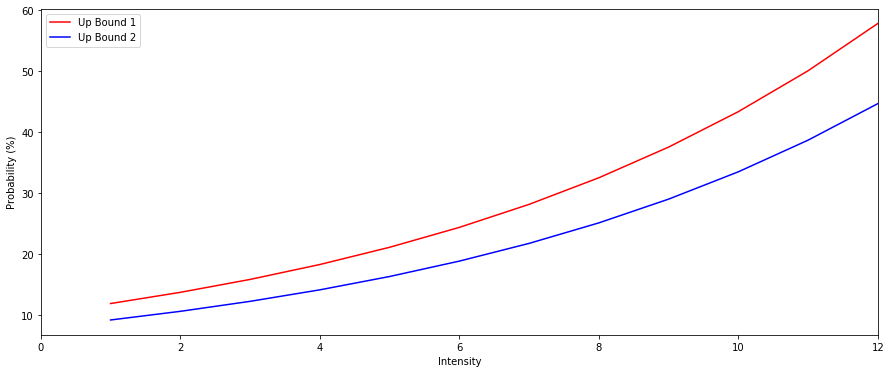

In [12]:
plt.figure(figsize=(15,6))
plt.plot(lambdaa,bound1,label='Up Bound 1',color='red')
plt.plot(lambdaa,bound2, color='blue', label='Up Bound 2')
#plt.plot(lambdaa,PP,color='green',label='Simulated Ruin Probability')
plt.xlabel('Intensity')
plt.ylabel('Probability (%)')
plt.xlim(0,np.max(lambdaa))
plt.legend([r'$e^{-v_0^+ x}e^{\eta_0^+ \lambda}$',r'$\frac{\gamma - v_0^+}{\gamma}e^{-v_0^+ x}e^{\eta_0^+ \lambda}$'])

Bajo la nueva medida se cambian los parámetros de la siguiente manera

In [13]:
a2=round((1+delta*etta_0)*a,4)
c2=c
delta2=delta
rho2=round((alpha*rho)/(alpha-etta_0),4)
gamma2=round(gamma-v_0,4)
beta2=round((beta-etta_0)/(1+delta*etta_0),4)
alpha2=round((alpha-etta_0)/(1+delta*etta_0),4)
lambda2=round((1+delta*etta_0)*lambda0,4)
m_0=round(etta_0/(etta_0*delta+1),4)
phi=round((gamma -v_0)/gamma,4)
vector1=['a2','c2','delta2','rho2','gamma2','beta2','alpha2','lambda2','etta_0','v_0','m_0','phi']
vector2=[a2,c2,delta2,rho2,gamma2,beta2,alpha2,lambda2,etta_0,v_0,m_0,phi]
new_values= Table([vector1, vector2], names=('Parameters', 'Values'))
new_values

Parameters,Values
str7,object
a2,1.0026
c2,1.5
delta2,3.0
rho2,0.5388
gamma2,0.7724
beta2,0.9467
alpha2,1.2957
lambda2,1.0026
etta_0,0.144101998768582


In [54]:
def ruina_ok(a,rho,delta,alpha,beta,gamma,lambda0,T,x_0,c,sim):
    initial=0
    i=0
    ruinas=[]
    while initial<sim:
        Ti,Nt,N,lambdat,sizeSJ,sizeEJ=simulation3(a,rho,delta,alpha,beta,lambda0,T)
        Nt_final=[]
        z=[]
        while i <(len(Nt)):
            y=np.random.exponential(scale=1/gamma)
            z.append(y)
            if i==0:
                h=Nt[0]

            else:
                h=Nt[i]-Nt[i-1]
            Nt_final.append(h)    
            i=i+1
            if i ==10000000:
                break
        Ti_S = list(map(operator.mul, Ti, Nt_final))
        z_S = list(map(operator.mul, z, Nt_final))
        X_t=[]
        j=0
        
        while i<len(Ti):
            xt=x_0+c*(Ti[j])-np.cumsum(z_S)[j]
            X_t.append(xt)
            j=j+1
            if j==2000000:
                break
        ruina1=[]
        for number in X_t:
            if number <0:
                ruina1.append(1)
                break
            else:
                ruina1.append(0)
        ruinas.append(lambdat[len(ruina1)-1])
        initial=initial+1
        
        
    return ruinas

In [69]:
ruinas=ruina_ok(a2,rho2,delta2,alpha2,beta2,gamma2,lambda2,T,0,c2,10000)

C:\Users\hsrc_\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


La probabilidad de ruina será determinada bajo el cambio de medida como:

In [71]:
x=x_0
term1=(rho2*(alpha2-beta2))/(delta2*(alpha2-beta2)+1)
term2=(1/delta2)*(a2+(rho2/(delta2*(alpha2-beta2)+1)))
term3=(delta2*beta2-1)/delta2
term4=(((a2*delta2)+(rho2/(alpha2+m_0)))/(delta2-(1/(beta2+m_0))))
expected1=((alpha2/(alpha2-m_0))**(term1))*((term3/(term3-m_0))**(term2))*exp(m_0*a2)
expected2=((alpha2/(alpha2+m_0))**(term1))*((term3/(term3+m_0))**(term2))*term4*exp(-m_0*a2)
expected3=((rho2/alpha2)+a2*delta2)/(delta2-(1/beta2))
expected5=np.mean(np.exp(np.dot(-m_0,ruinas)))
print(expected1,expected2)

1.20186293020250 1.39741547640622


Aproximación de la probabilidad de ruina 

In [72]:
C=((phi*(beta-etta_0))/(beta))*expected1*(((expected2/gamma2)-c2*expected5)/((expected3/gamma2)-c2))
prob2=C*exp(-v_0*x)
print(C,prob2)

0.613885693794713 0.613885693794713


Probabilidad de ruina bajo la nueva medida para distintos valores de la reserva

In [73]:
for x in range(4,32,2):
    C=((phi*(beta-etta_0))/(beta))*expected1*(((expected2/gamma2)-c2*expected5)/((expected3/gamma2)-c2))
    prob2=C*exp(-v_0*x)
    print(prob2)

0.246980728408695
0.156657374761145
0.0993661862817218
0.0630269656390461
0.0399773660066112
0.0253572383918868
0.0160838395095026
0.0102018165136708
0.00647090889691574
0.00410443197993931
0.00260339963771984
0.00165131002457983
0.00104740922514151
0.000664361063992624
